In [1]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
#plt.gray()
galaxy_name = 'DDO69'

# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO69\d69_u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO69\d69_b.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO69\d69_v.fits")
light_v = light_file_v[0].data

box_u = (250 , 300) 
box_b = (250 , 300) 
box_v = (250 , 300) 

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]
print(np.shape(light_u), np.shape(light_b),np.shape(light_v))

(984, 984) (877, 944) (877, 944)


In [2]:
import astroalign as aa
target_fixed = lights[0].byteswap().newbyteorder('N')
source_fixed_1 = lights[1].byteswap().newbyteorder('N')
source_fixed_2 = lights[2].byteswap().newbyteorder('N')
registered_image_1, footprint_1 = aa.register(source_fixed_1, target_fixed)
registered_image_2,  footprint_2 = aa.register(source_fixed_2, target_fixed)
list_of_aligned_images = [lights[0],registered_image_1, registered_image_2 ]
print(np.shape(list_of_aligned_images[0]),(np.shape(list_of_aligned_images[1]),np.shape(list_of_aligned_images[2])))
aligned = list_of_aligned_images

(984, 984) ((984, 984), (984, 984))


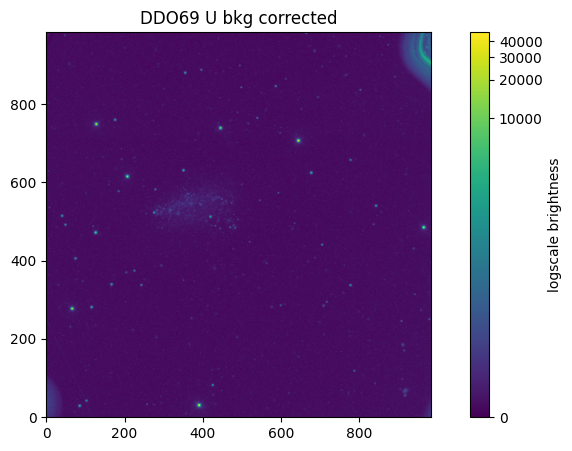

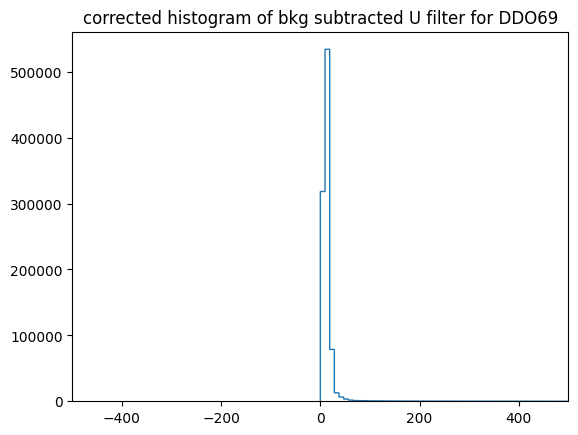

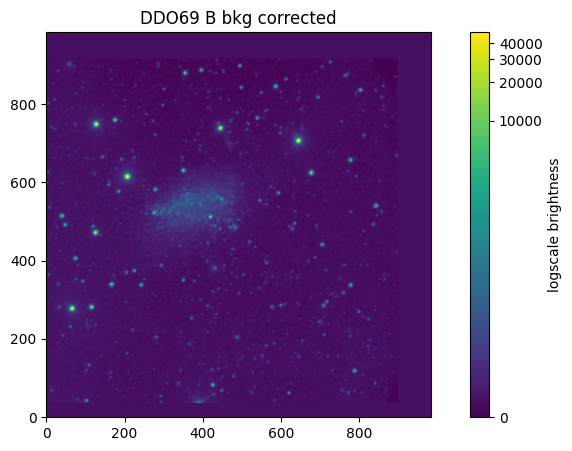

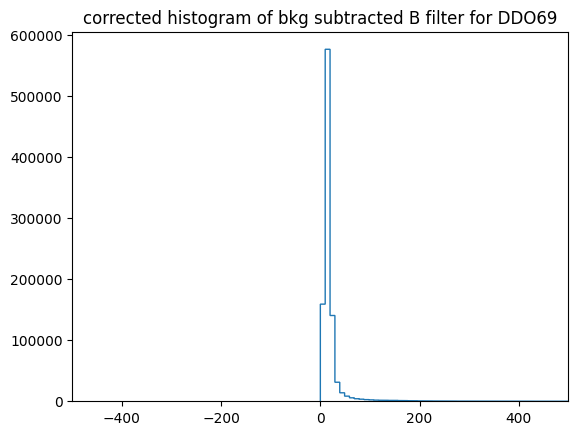

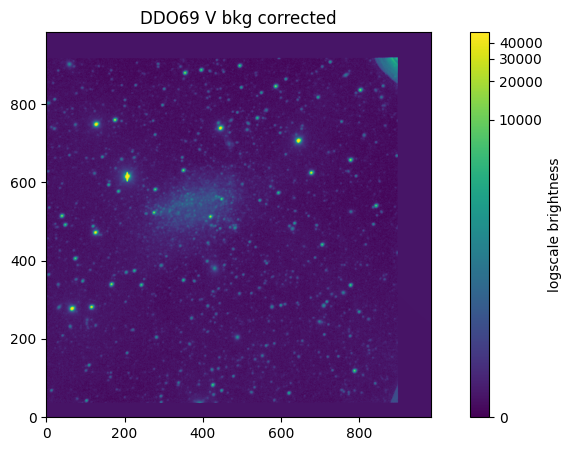

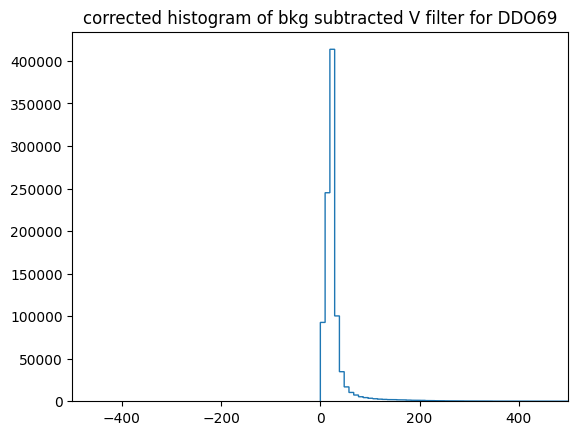

In [3]:
corrected = ltf.background_subtraction(aligned,3,boxes,(3,3))
for i in range(0,3):
    ltf.log_scale_plot(corrected[i],"%s %s bkg corrected"%(galaxy_name,filters[i]),"logscale brightness")
    output_filename = '%s_%s_background_subtracted.fits'%(galaxy_name,filters[i])
    # Create a PrimaryHDU (header/data unit) from your array
    primary_hdu = fits.PrimaryHDU(corrected[i])
    # Create an HDUList and append the PrimaryHDU
    hdul = fits.HDUList([primary_hdu])
    # Write the HDUList to the FITS file
    #hdul.writeto(output_filename, overwrite=True)
    counts, bins = np.histogram(corrected[i], 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("corrected histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()

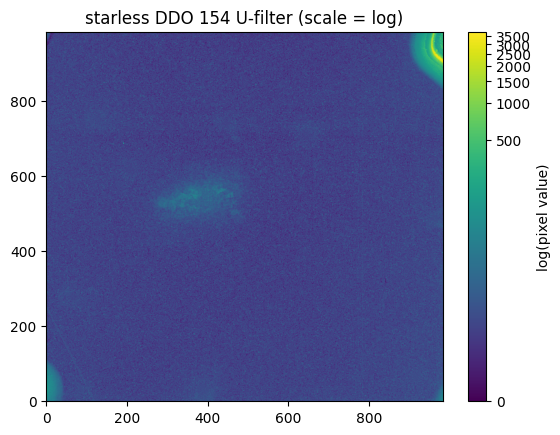

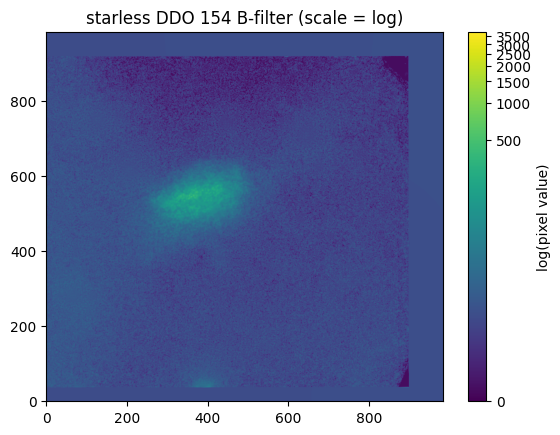

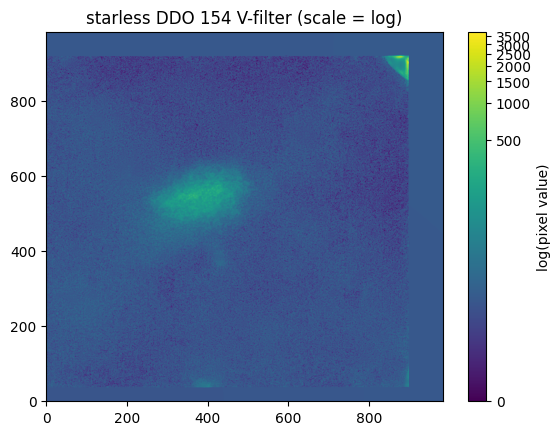

In [4]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------
starless_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d69\starless1\starless_DDO69_U_background_subtracted.fit")
starless_u = starless_file_u[0].data
starless_u[starless_u <= 0] = 1
starless_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d69\starless1\starless_DDO69_B_background_subtracted.fit")
starless_b = starless_file_b[0].data
starless_b[starless_b <= 0] = 1
starless_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d69\starless1\starless_DDO69_V_background_subtracted.fit")
starless_v = starless_file_v[0].data
starless_v[starless_v <= 0] = 1

starless = [starless_u , starless_b , starless_v]

norm = ImageNormalize(vmin=0., stretch=LogStretch())
for i in range(0 , len(starless)):
    
    plt.imshow(starless[i] , origin = "lower" , aspect='auto', norm = norm)
    plt.title('starless DDO 154 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

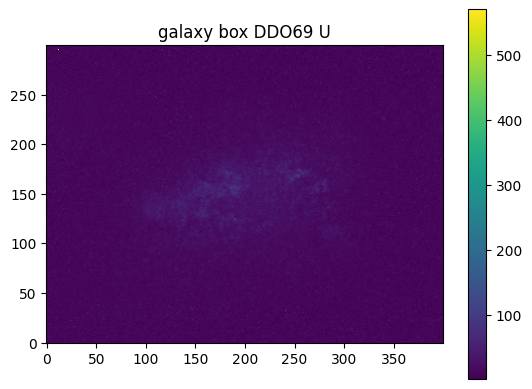

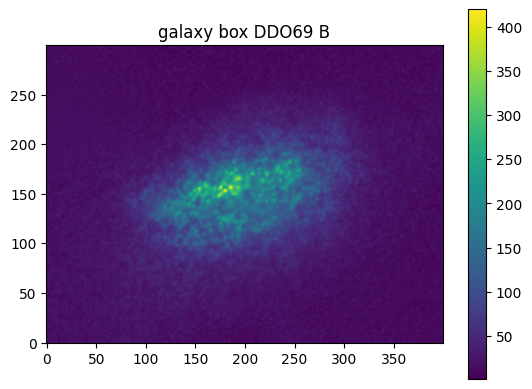

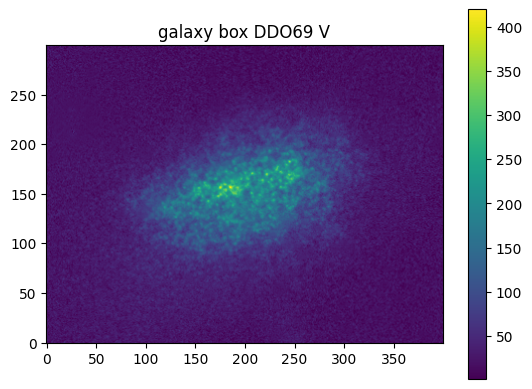

In [5]:
import little_things_functions as ltf
box_size_x = 200
box_size_y = 150
box_center = (540,380)
image_boxes = []
for i in range(0 , len(starless)):
        box = starless[i][540 - box_size_y : 540 + box_size_y, 380 - box_size_x : 380 + box_size_x]
        image_boxes.append(box)
for i in range(0,3):
    plt.imshow(image_boxes[i], origin = "lower")
    plt.title("galaxy box %s %s"%(galaxy_name,filters[i]))
    plt.colorbar()
    plt.show()
v_value_box = image_boxes[2]

In [6]:
#sina
'''
import Galaxy_Processing as GP
import numpy as np
v_value_box = galaxy_boxes[2]
GP.image_show(v_value_box, "v")
smoothed = gaussian_filter(v_value_box,5)
sth  = GP.half_radius_ellipse(smoothed, v_value_box, np.arange(np.min(v_value_box), np.max(v_value_box)),galaxy_name, [80,150], plot = True, fit = False)
'''

'\nimport Galaxy_Processing as GP\nimport numpy as np\nv_value_box = galaxy_boxes[2]\nGP.image_show(v_value_box, "v")\nsmoothed = gaussian_filter(v_value_box,5)\nsth  = GP.half_radius_ellipse(smoothed, v_value_box, np.arange(np.min(v_value_box), np.max(v_value_box)),galaxy_name, [80,150], plot = True, fit = False)\n'

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_14124\1210612200.py:10: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for item in contours.collections:


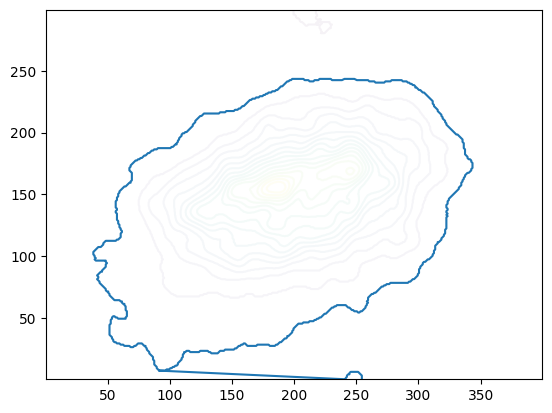

In [7]:
#golta:
v_value_box = image_boxes[2]

smoothed_v_box = gaussian_filter(v_value_box, 5)
contours = plt.contour(smoothed_v_box, origin='lower', alpha=0.05, levels=np.arange(smoothed_v_box.min(), smoothed_v_box.max(), 15))
#contours = plt.contour(data, origin='lower', alpha=0.05)

len_of_ver=[]
path_arr=[]
for item in contours.collections:
    for path in item.get_paths():
        len_of_ver.append(len(path.vertices[:, 0]))
        path_arr.append(path)
    
path_element=np.argmax(len_of_ver)
vertices=path_arr[path_element].vertices
#plt.plot(vertices[:, 0]*pixel_scale, vertices[:, 1]*pixel_scale, color='r', linewidth=1)

x, y = vertices[:, 0], vertices[:, 1]

plt.plot(x,y)


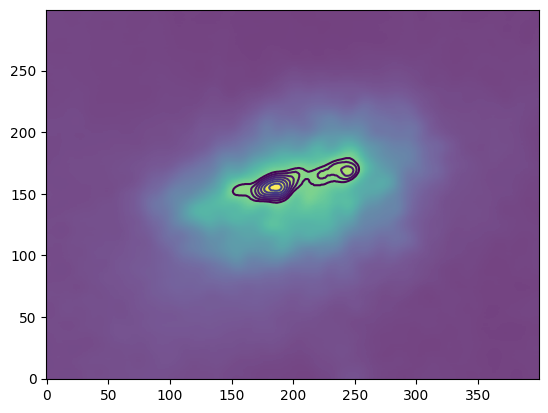

In [17]:
levels = np.asanyarray(np.arange(200, 500, 10))
ltf.contour_lines(v_value_box, 5, levels)

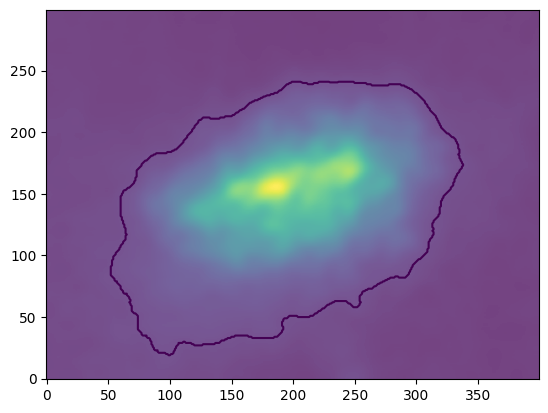

In [9]:
# mine
contour_points = ltf.contour_lines_coordinates(v_value_box, 5, [30])
x_points , y_points = contour_points

(145.4715666711053, 196.24684216223775)
[190.68608923 135.71804232 152.00485425  92.64501766   0.45582041]


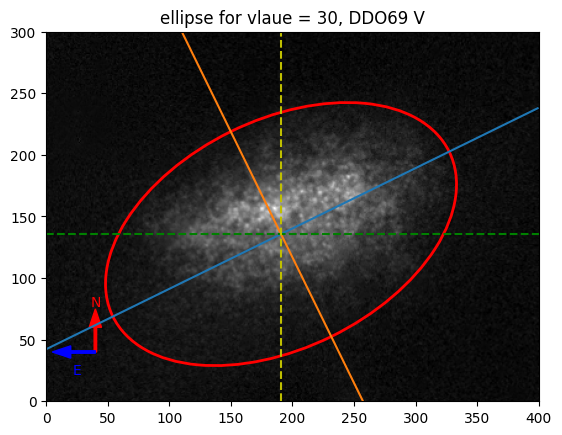

what we are reporting is 26.116585949797116 from the green line toward the semi_major axis
i guess little things is measuring yellow to blue toward east -63.88341405020289
paper = -64


In [10]:
image_center_of_mass = ndimage.center_of_mass(v_value_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_value_box, cmap='gray' , origin = "lower")
angle_in_degrees = np.degrees(theta)
# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)
# Add the ellipse to the axis

ax.add_patch(ellipse)
m = np.tan(theta)
x_ax = np.arange(0,400)
Y_ax = m*(x_ax-xc) + yc
ax.plot(x_ax,Y_ax)

Y_prime_ax = (-1/m)*(x_ax-xc) + yc
ax.plot(x_ax,Y_prime_ax)

plt.axhline(y=yc, color='g', linestyle='--', label='theta = 0')
plt.axvline(x=xc,  color='y', linestyle='--')

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for vlaue = 30, DDO69 V")
# Show the plot
# Example: Add arrows for north and east
plt.arrow(x=40, y=40, dx=0, dy=20, color='red', width=2, head_width=10)
plt.arrow(x=40, y=40, dx=-20, dy=0, color='blue', width=2, head_width=10)
plt.text(40, 80, 'N', color='red', fontsize=10, ha='center', va='center')
plt.text(25, 25, 'E', color='blue', fontsize=10, ha='center', va='center')

plt.show()
import math
angle_in_degrees = math.degrees(theta)

print("what we are reporting is" , angle_in_degrees , "from the green line toward the semi_major axis")
print("i guess little things is measuring yellow to blue toward east" , -1*(90-angle_in_degrees))
print("paper = -64")

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_14124\2646981734.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry


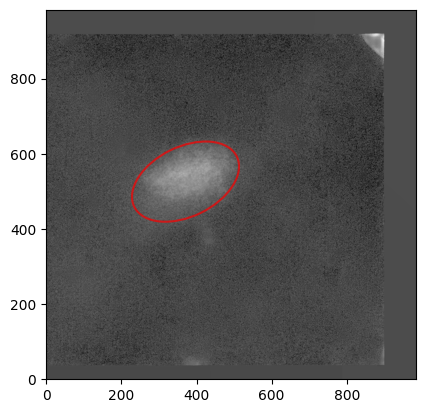

Aperture sum for 'elliptical aperture': 3569215.7


In [11]:
from astropy.coordinates import Angle
from photutils.aperture import EllipticalAperture
from photutils import aperture_photometry
elliptical_center_box = (xc,yc)
new_xc = xc + (box_center[1]-box_size_x)
new_yc = yc + (box_center[0]-box_size_y)
elliptical_center = (new_xc,new_yc)
ellipse_aper = EllipticalAperture(elliptical_center, a, b, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(starless[2], cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper.plot(color='red', lw=1.5, alpha=0.7) 
plt.show()
phot_table = aperture_photometry(starless[2], ellipse_aper)
aperture_sum_A = phot_table['aperture_sum'][0] 

print(f"Aperture sum for 'elliptical aperture': {aperture_sum_A:.8g}")

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_14124\3944444723.py:3: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry
C:\Users\AYSAN\AppData\Local\Temp\ipykernel_14124\3944444723.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry


Aperture sums: [5.560618996853934e-10, 3210.437133688181, 12608.469859133216, 28218.933476076214, 50406.30648898802, 77981.23285465203, 111690.08527508669, 153745.17027154483, 203430.7742387472, 257315.41121827162, 318815.72437855287, 388203.810703089, 461924.7595225954, 539180.6198044514, 624660.415269271, 713325.6853642561, 804712.2315066436, 898507.843435174, 995982.5013817686, 1096278.9697299292, 1200299.093944917, 1309789.092097616, 1415910.665575846, 1518123.8222346052, 1618485.3408990565, 1717661.2773313818, 1814815.4578101363, 1911120.9027698766, 2005718.182597028, 2098851.5169719383, 2187084.4722187445, 2271062.5557837463, 2355129.4426039527, 2437594.775895469, 2519217.5027126884, 2598983.898619191, 2677569.463383361, 2755112.4168186146, 2830820.20076714, 2904474.7107349453, 2976093.9284625174, 3045898.328078495, 3112647.716245589, 3179463.3275602013, 3243714.6714390144, 3307049.4399530673, 3369220.3555781944, 3428771.8447679915, 3486979.791095744, 3542078.1659699637, 3596034.

Text(0.5, 1.0, ' curve of growth for DDO69')

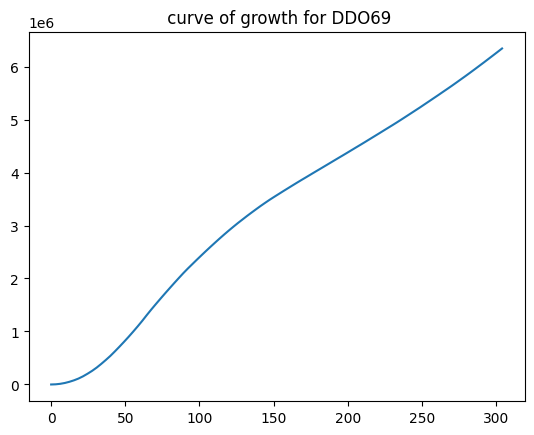

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from photutils import EllipticalAperture, aperture_photometry

# Assuming you have defined 'a', 'b', 'theta', 'elliptical_center', and 'v_value_box'
ab_ratio = a / b
ba_ratio = b / a
a_list = np.linspace(0, 2 * a, 100)
b_list = ba_ratio * a_list

sum_values = []

for i in range(len(a_list)):
    # Ensure positive scalar values for major and minor axes
    a_i = max(a_list[i], 1e-6)  # Avoid zero or negative values
    b_i = max(b_list[i], 1e-6)
    ellipse_aper = EllipticalAperture(elliptical_center, a_i, b_i, theta)
    '''
    plt.imshow(starless[2], cmap='gray')  # Replace 'image_data' with your data
    ellipse_aper.plot(color='red', lw=1.5, alpha=0.7)  # Overlay the aperture
    plt.show()
    '''
    # Compute the aperture sum
    phot_table = aperture_photometry(starless[2], ellipse_aper)
    aperture_sum_A = phot_table['aperture_sum'][0]
    sum_values.append(aperture_sum_A)

print("Aperture sums:", sum_values)

plt.plot(a_list , sum_values)
plt.title(" curve of growth for DDO69")


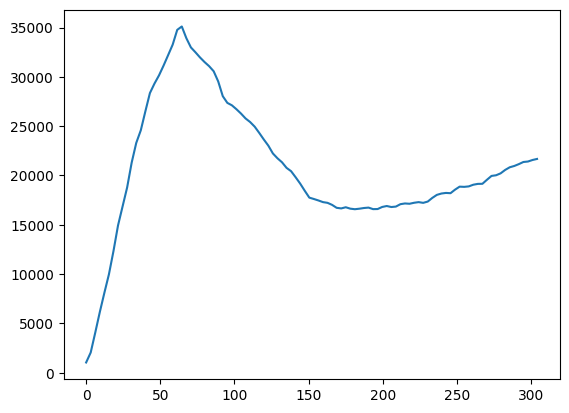

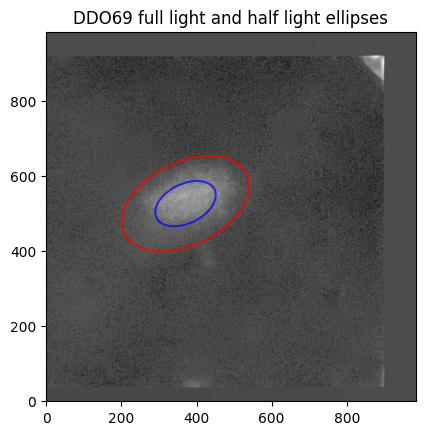

galaxy parameter a =  181.17750304250237 and galaxy parameter b =  110.42537458448815
galaxy count 4065600.433119644
galaxy half light a =  85.98254381678079 and galaxy half light b =  52.405262514672344
half light count 2005718.182597028
0.4933387369446896


In [13]:
gradient_sum = np.gradient(sum_values, a_list)
plt.plot(a_list, gradient_sum)
plt.show()
import numpy as np
from scipy.signal import find_peaks
peaks, _ = find_peaks(gradient_sum)
peak_index = peaks[0]
min_after_peak = np.min(gradient_sum[peak_index + 1:])
min_index_after_peak = np.where(gradient_sum == min_after_peak)[0][0]

galaxy_parameter_a = a_list[min_index_after_peak]
galaxy_parameter_b = galaxy_parameter_a*ba_ratio
whole_galaxy = sum_values[min_index_after_peak]

half_light_estimated = whole_galaxy/2
half_light_index = min(range(len(sum_values)), key=lambda i: abs(sum_values[i] - half_light_estimated))

a_half_light = a_list[half_light_index]
b_half_light = a_half_light * ba_ratio

ellipse_aper_full_light = EllipticalAperture(elliptical_center, galaxy_parameter_a, galaxy_parameter_b, theta)
ellipse_aper_half_light = EllipticalAperture(elliptical_center, a_half_light, b_half_light, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(starless[2], cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper_full_light.plot(color='red', lw=1.5, alpha=0.7) 
ellipse_aper_half_light.plot(color='blue', lw=1.5, alpha=0.7)
plt.title("%s full light and half light ellipses" %(galaxy_name))
plt.show()

print("galaxy parameter a = ", galaxy_parameter_a, "and galaxy parameter b = " , galaxy_parameter_b)
print("galaxy count", sum_values[min_index_after_peak])
print("galaxy half light a = ", a_half_light, "and galaxy half light b = " , b_half_light)
print("half light count", sum_values[half_light_index])
ratio = sum_values[half_light_index]/whole_galaxy
print(ratio)

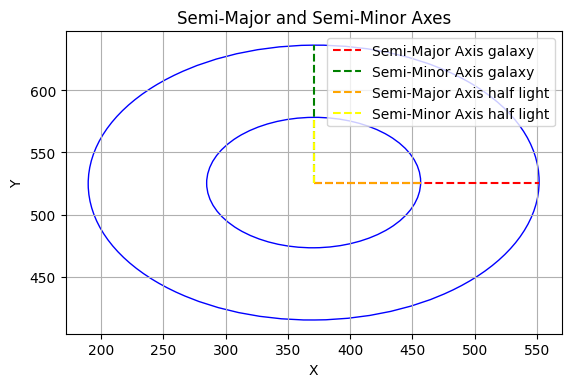

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Define ellipse parameters
h, k = elliptical_center  # Center coordinates

theta = theta  # Angle of rotation (if any)

# Create an ellipse
ellipse_galaxy = Ellipse((h, k), 2 * galaxy_parameter_a, 2 * galaxy_parameter_b, angle=theta, fill=False, color='blue')
ellipse_half = Ellipse((h, k), 2 * a_half_light, 2 * b_half_light, angle=theta, fill=False, color='blue')
# Set up the plot
fig, ax = plt.subplots()
ax.add_patch(ellipse_galaxy)
ax.add_patch(ellipse_half)
ax.set_aspect('equal')  # Equal aspect ratio for x and y axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Semi-Major and Semi-Minor Axes')
plt.grid(True)

# Draw semi-major and semi-minor axes
ax.plot([h, h + galaxy_parameter_a], [k, k], color='red', linestyle='--', label='Semi-Major Axis galaxy')
ax.plot([h, h], [k, k + galaxy_parameter_b], color='green', linestyle='--', label='Semi-Minor Axis galaxy')

ax.plot([h, h + a_half_light], [k, k], color='orange', linestyle='--', label='Semi-Major Axis half light')
ax.plot([h, h], [k, k + b_half_light], color='yellow', linestyle='--', label='Semi-Minor Axis half light')

# Show the legend
ax.legend()

# Display the plot
plt.show()


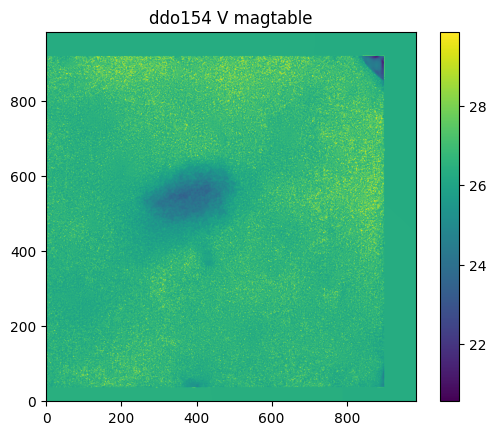

NameError: name 'galaxy_boxes' is not defined

In [15]:
pixel_scale = 1.134
exposures = [1800, 2400, 1200]
airmass_values=[1.22, 1.04, 1.1]
mU_values = [5.251, 0.459, -0.121, 0]
mV_values = [3.009, 0.2183592, 0.0415, 0.]
mB_values = [3.434, 0.3398903,-0.0157, 0.]
m_values = [mU_values,mB_values,mV_values]
 
plt.imshow(ltf.mag_table_correction(starless,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

plt.imshow(ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

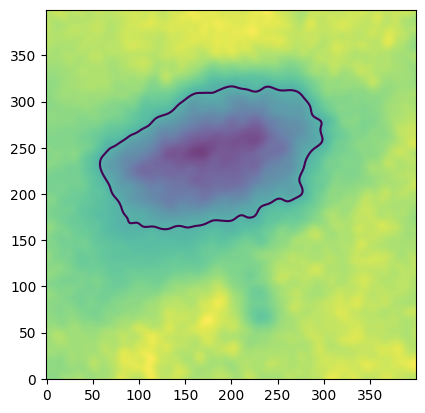

In [ ]:
v_box = ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2]
contour_points = ltf.contour_lines_coordinates(v_box, 5, [25])
x_points , y_points = contour_points

In [ ]:
image_center_of_mass = ndimage.center_of_mass(v_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]

(199.07608097977203, 200.10004577496247)


[181.72691099 238.56037294 122.23204205  70.09479526   0.3041347 ]


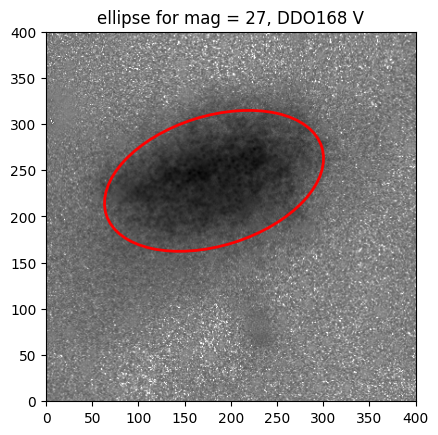

In [ ]:
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_box.shape[1])
ax.set_ylim(0,v_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for mag = 27, DDO168 V")
# Show the plot
plt.show()